# Практическая работа №2
 Выполнил студент группы ББМО-02-23 Сидоренков Никита Дмитриевич

# Задачи:
1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы FGSM.
3. Реализовать атаку FGSM и сгенерировать противоречивые примеры.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.


# Шаги выполнения:
Шаг 1: Загрузка обученной модели и данных MNIST
Используйте сохраненную модель из предыдущей практики. Загрузите её и тестовые данные для
дальнейшего анализа.


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в категориальный формат
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')
# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels)  # Обратите внимание на изменение формы
print(f'Test accuracy on clean images: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9709 - loss: 0.0959
Test accuracy on clean images: 0.9750


# Шаг 2: Теория FGSM
Атака Fast Gradient Sign Method (FGSM) — это метод генерации противоречивых примеров, который
изменяет пиксели изображения на минимальные величины, направленные на ухудшение предсказаний
модели. FGSM использует градиент потерь по отношению к входному изображению и добавляет
небольшие изменения, чтобы максимизировать ошибку предсказания.
Формула атаки:
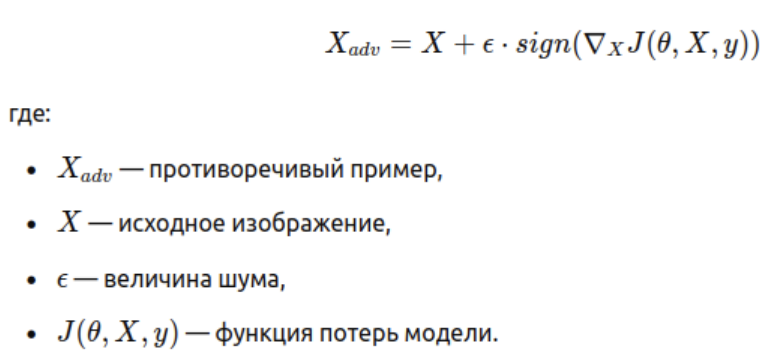

# Шаг 3: Реализация атаки FGSM
Теперь реализуем FGSM для генерации противоречивых примеров.

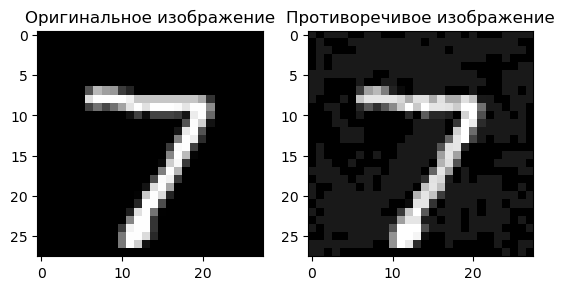

In [2]:
import numpy as np
# Функция для реализации FGSM атаки
def fgsm_attack(image, epsilon, gradient):
 # Применение знака градиента к изображению
 perturbed_image = image + epsilon * np.sign(gradient)
 # Обрезка значений, чтобы они оставались в пределах [0,1]
 perturbed_image = np.clip(perturbed_image, 0, 1)
 return perturbed_image
# Вычисление градиента
def generate_adversarial_example(model, image, label, epsilon):
  # Превращение изображения в формат, подходящий для модели
  image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)
  # Получение градиента по отношению к входному изображению
  gradient = tape.gradient(loss, image)
  # Применение FGSM
  adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
  return adversarial_image
# Пример использования
epsilon = 0.1 # Величина шума
adversarial_example = generate_adversarial_example(model, test_images[0],
test_labels[0], epsilon)
# Вывод результатов
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.show()

# Шаг 4: Оценка модели на противоречивых примерах
Теперь мы проверим точность модели на противоречивых изображениях, сгенерированных при
помощи FGSM.


In [3]:
# Генерация противоречивых примеров для всего набора данных
def generate_adversarial_dataset(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        # Генерация противоречивого изображения
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image)
    return np.array(adversarial_images)
# Генерация противоречивых примеров
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon)
# Оценка модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images.reshape(-1, 28, 28, 1), test_labels)
print(f'Точность на противоречивых примерах: {adversarial_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.0798 - loss: 6.8161
Точность на противоречивых примерах: 0.1035


# Шаг 5: Сравнение результатов

In [4]:
print(f'Точность на чистых изображениях: {test_acc:.4f}')
print(f'Точность на противоречивых примерах: {adversarial_acc:.4f}')

Точность на чистых изображениях: 0.9750
Точность на противоречивых примерах: 0.1035


# Вывод:
Разница в точности модели между обычными и противоречивыми примерами является впечатляющей. Точность на обычных примерах составляет около 97,5%, тогда как на противоречивых — всего 10,4%. Это указывает на уязвимость модели к атакам, что является распространенной проблемой в области машинного обучения.

Такое резкое снижение точности говорит о том, что модель не справляется с задачей распознавания в условиях небольших, но целенаправленных искажений. Это подчеркивает важность разработки более устойчивых моделей и применения методов защиты от атак для повышения надежности в реальных приложениях.